# Grilla CBA capital
Se armará una grilla de 20x20 a partir de los radios censales de la Ciudad de Córdoba. 

Se cargan librerías.

In [1]:
import geopandas as gpd, pandas as pd, numpy as np, matplotlib.pyplot as plt
from shapely.geometry import box
import random
import contextily as cx
import folium
from branca.colormap import linear
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

Se obtiene los radios censales de [aquí.](https://gobiernoabierto.stage.cordoba.gob.ar/data/datos-abiertos/categoria/geografia-y-mapas/radios-censales/236)

Text(0.5, 1.0, 'Circuitos electorales')

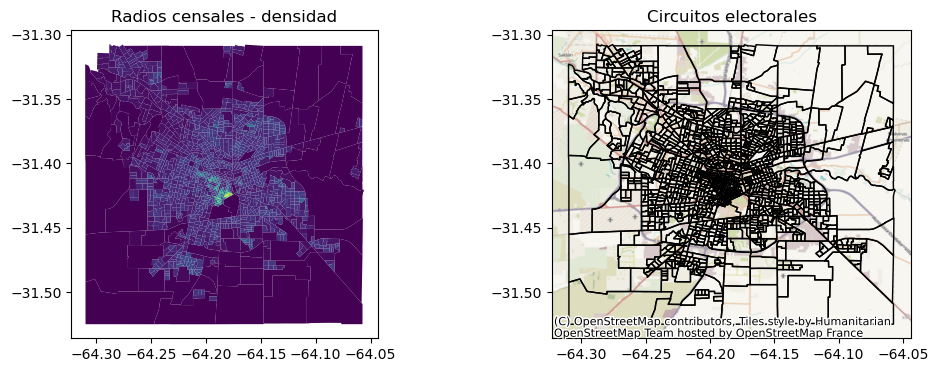

In [2]:
path = 'Cordoba-Radios-Censales.csv'
rad = gpd.read_file(path)
filtro = rad['link'].apply(lambda x: x[:5])=='14014' # filtro córdoba capital
rad = rad[filtro]

rad = rad.set_crs('epsg:4326')
rad['totalpobl'] = rad['totalpobl'].astype(float)
rad['AREA_str'] = rad['AREA']
rad['AREA'] = rad['AREA'].astype(float)
rad['densidad'] = rad['totalpobl'] / (rad['AREA']/1000000)

fig, axes = plt.subplots(1,2, figsize=(12,4))
rad.plot(column='densidad', ax = axes.flatten()[0])
rad.plot(facecolor='none', ax = axes.flatten()[1])
cx.add_basemap(axes.flatten()[1], crs=rad.crs)
axes.flatten()[0].set_title('Radios censales - densidad')
axes.flatten()[1].set_title('Circuitos electorales')

Se construye la grilla teniendo como límite los radios censales del año 2010.

In [3]:
# Combinar todas las geometrías para obtener el límite de la ciudad
city_boundary = rad.unary_union

# Extensión de la ciudad
minx, miny, maxx, maxy = city_boundary.bounds

# Número de filas y columnas
rows = 20
cols = 20

# Tamaño de cada celda
cell_width = (maxx - minx) / cols
cell_height = (maxy - miny) / rows

# Crear la grilla
grid_cells = []
for i in range(cols):
    for j in range(rows):
        x1 = minx + i * cell_width
        y1 = miny + j * cell_height
        x2 = x1 + cell_width
        y2 = y1 + cell_height
        grid_cells.append(box(x1, y1, x2, y2))

# Crear un GeoDataFrame para la grilla
grid = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=rad.crs)

# Recortar la grilla al área de la ciudad
grid = (gpd
        .clip(grid, city_boundary)
        .assign(rdn = [random.randint(1,1000) for i in range(400)],
                idx =range(1,401))
       )

grid.explore(column='rdn')

Se construye una variable de densidad promedio que nos servirá luego para descartar los puntos de la grilla que estén demasiado alejados de la ciudad. 

(1493, 14)
(400, 3)
(3248, 5)
(400, 3)


,idx,densidad_promedio
count,400.0,400.0
mean,200.5,3109.8
std,115.6,3740.1
min,1.0,2.1
25%,100.8,80.8
50%,200.5,1467.1
75%,300.2,5764.6
max,400.0,24310.1


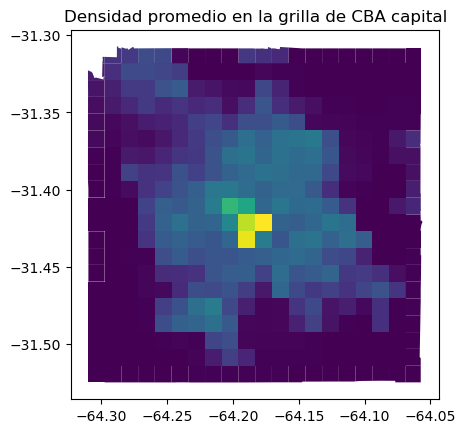

In [4]:
print(rad.shape)
print(grid.shape)
join = gpd.sjoin(rad[['densidad','geometry']], grid, how='inner', predicate='intersects')
print(join.shape)
density_avg = join.groupby('index_right')['densidad'].mean()
grid['densidad_promedio'] = grid.index.map(density_avg)
grid['densidad_promedio'] = grid['densidad_promedio'].fillna(0)
grid = grid.drop(columns=['rdn'])
print(grid.shape)
display(grid.describe().style.background_gradient().format('{:.1f}'))

grid.plot(column='densidad_promedio', legend=False)
plt.title('Densidad promedio en la grilla de CBA capital');

Para trabajar el mapa de manera más adecuada, se divide por grupos según distintos criterios: por deciles y utilizando K-Means.

In [5]:
# definiciones
k = 10
seed=42

In [6]:
# deciles
grid["decil"] = pd.qcut(grid["densidad_promedio"], q=k, labels=False)
grid['decil'] = grid['decil']+1
print('densidad promedio por decil')
display(grid.groupby('decil')['densidad_promedio'].describe().style.background_gradient().format('{:.1f}'))

densidad promedio por decil


,count,mean,std,min,25%,50%,75%,max
decil,,,,,,,,
1,46.0,9.6,9.6,2.1,2.3,3.3,19.2,25.1
2,37.0,44.0,12.5,27.5,31.7,47.9,51.5,62.2
3,39.0,85.4,15.5,62.9,75.2,80.8,99.1,112.7
4,38.0,161.9,51.7,113.0,121.7,141.3,183.3,300.9
5,40.0,695.9,319.6,325.6,429.3,597.7,937.4,1444.3
6,40.0,2454.4,589.4,1490.0,1958.9,2494.4,2949.4,3355.7
7,40.0,4073.6,489.0,3370.8,3663.7,4036.0,4529.4,5008.3
8,40.0,5808.1,431.4,5065.3,5451.0,5771.9,6167.6,6497.6
9,40.0,7362.4,434.5,6651.0,6964.7,7369.6,7709.1,8085.6


In [7]:
# K-Means
values = grid["densidad_promedio"].values.reshape(-1, 1)

# Aplicar K-Means
kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
grid["natural_breaks"] = kmeans.fit_predict(values)

# Ordenar los clusters por valor promedio
cluster_means = grid.groupby("natural_breaks")["densidad_promedio"].mean()
cluster_mapping = {k: i for i, k in enumerate(cluster_means.sort_values().index)}
grid["natural_breaks"] = grid["natural_breaks"].map(cluster_mapping)
grid["natural_breaks"] += 1
print('densidad promedio por agrupamiento K-Means')
display(grid.groupby('natural_breaks')['densidad_promedio'].describe().style.background_gradient().format('{:.1f}'))

densidad promedio por agrupamiento K-Means


,count,mean,std,min,25%,50%,75%,max
natural_breaks,,,,,,,,
1,187.0,134.6,171.7,2.1,27.5,78.7,137.5,817.8
2,32.0,1579.6,477.3,918.8,1136.9,1578.0,1993.3,2385.8
3,37.0,3221.4,387.4,2473.0,2862.1,3280.5,3510.0,3808.5
4,26.0,4452.6,371.5,3901.5,4117.5,4514.1,4715.7,5096.1
5,35.0,5791.1,375.2,5211.2,5464.3,5757.2,6124.5,6435.1
6,34.0,7131.0,376.1,6488.0,6847.0,7184.0,7482.3,7713.2
7,32.0,8442.1,401.5,7840.7,8081.1,8413.5,8770.3,9062.7
8,12.0,9817.1,545.6,9269.4,9396.3,9715.5,10116.7,11216.5
9,2.0,15214.1,1228.4,14345.5,14779.8,15214.1,15648.4,16082.7


Es un poco más adecuada la definición por K-Means. Se utilizará en el mapa.

In [8]:
grid["grupo"] = grid["natural_breaks"]

Se crea un mapa con capacidad de filtrar por grupo para decidir. 

In [9]:
# Crear el mapa base
mapa = folium.Map(location=[grid.geometry.centroid.y.mean(), grid.geometry.centroid.x.mean()], zoom_start=12)

# Definir el esquema de colores para los cuantiles
colormap = linear.RdYlGn_11.scale(grid["densidad_promedio"].min(), grid["densidad_promedio"].max())
colormap.caption = "Densidad Promedio"

# Agregar cada cuantil como una capa separada para poder filtrar
for grupo in grid["grupo"].sort_values().unique():
    layer = folium.FeatureGroup(name=f"grupo {grupo}")
    subgrid = grid[grid["grupo"] == grupo]

    # Agregar los polígonos al mapa
    for _, row in subgrid.iterrows():
        folium.GeoJson(
            row.geometry,
            style_function=lambda feature, densidad=row["densidad_promedio"]: {
                "fillColor": colormap(densidad),
                "color": "black",
                "weight": 0.5,
                "fillOpacity": 0.6,
            },
            tooltip=folium.Tooltip(f"ID: {row['idx']}<br>Densidad promedio: {row['densidad_promedio']:.2f}")
        ).add_to(layer)

    layer.add_to(mapa)

# Agregar el colormap al mapa
colormap.add_to(mapa)

# Agregar control de capas
folium.LayerControl().add_to(mapa)

# Guardar el mapa como HTML
# mapa.save("grilla_cordoba.html")
mapa